In [1]:
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/pbs/home/c/cmurray/cluster_likelihood/modules/')
import simulation
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import corner
import pickle
import scipy.stats as stats
from matplotlib.cm import get_cmap


/pbs/home/c/cmurray/.conda/envs/sbi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Use DES y1 to get reasonable parameters for the mass-richness relation 

In [2]:
# Path to your FITS file
file_path = '/sps/euclid/Users/cmurray/clusters_likelihood/redmapper_y1a1_public_v6.4_catalog.fits.gz'

# Load the FITS file into an Astropy Table
redmapper_catalogue = Table.read(file_path, format='fits')


redmapper_catalogue.remove_columns( ['P_CEN', 'RA_CEN', 'DEC_CEN', 'ID_CEN', 'PZBINS', 'PZ'] )
redmapper_catalogue = redmapper_catalogue.to_pandas()

In [3]:
redmapper_catalogue

,ID,NAME,RA,DEC,Z_LAMBDA,Z_LAMBDA_ERR,LAMBDA,LAMBDA_ERR,S,Z_SPEC,COADD_OBJECTS_ID,MAG_AUTO_G,MAGERR_AUTO_G,MAG_AUTO_R,MAGERR_AUTO_R,MAG_AUTO_I,MAGERR_AUTO_I,MAG_AUTO_Z,MAGERR_AUTO_Z,ZLUM
0,1,b'RMJ025415.5-585710.7',43.564574,-58.952970,0.429804,0.012092,234.503677,7.524398,1.056760,-1.0,3089939451,20.175312,0.016915,18.321383,0.008136,17.693726,0.008200,17.325676,0.008411,-1.0
1,2,b'RMJ051637.4-543001.6',79.155704,-54.500456,0.304161,0.007928,195.069565,6.777896,1.054525,-1.0,3047101906,19.667797,0.006787,17.954527,0.002154,17.444197,0.002180,17.169514,0.002899,-1.0
2,3,b'RMJ041111.0-481939.6',62.795694,-48.327672,0.419369,0.012649,174.460098,5.073172,1.020732,-1.0,3069562192,19.575390,0.009780,17.845314,0.004595,17.227699,0.004688,16.868717,0.005000,-1.0
3,4,b'RMJ024524.8-530145.4',41.353375,-53.029288,0.301129,0.007855,146.238403,4.044031,1.009022,-1.0,3092286075,18.861450,0.006732,17.305017,0.003943,16.792620,0.004125,16.469460,0.005136,-1.0
4,5,b'RMJ224851.8-443106.3',342.215897,-44.518403,0.351486,0.010535,178.838272,8.712300,1.175402,-1.0,3138662814,19.863644,0.008220,18.214876,0.003940,17.675528,0.003998,17.349815,0.005363,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6724,33538,b'RMJ000918.5-552738.4',2.327241,-55.460656,0.535599,0.011719,21.117098,3.857398,1.139642,-1.0,3125722960,22.477217,0.046772,20.689310,0.016447,19.941771,0.015854,19.563747,0.018995,-1.0
6725,33839,b'RMJ041730.0-542204.2',64.374976,-54.367826,0.670123,0.019307,20.949293,3.114584,1.110266,-1.0,3067653261,23.217733,0.068689,21.364346,0.021354,20.297247,0.018293,19.863497,0.021155,-1.0
6726,36361,b'RMJ041818.0-454225.4',64.574808,-45.707065,0.599167,0.015502,21.132353,4.733696,1.269590,-1.0,3067376486,21.913805,0.055043,20.404688,0.031795,19.339394,0.028830,18.872198,0.029461,-1.0
6727,40510,b'RMJ011743.4-423414.0',19.430788,-42.570568,0.550219,0.011026,20.781488,3.890707,1.102398,-1.0,3114745735,22.120596,0.032472,20.347132,0.013752,19.534012,0.012425,19.149019,0.014458,-1.0


In [4]:
redmapper_catalogue['LAMBDA'].min(), redmapper_catalogue['LAMBDA'].max()

(20.003485, 234.50368)

In [5]:
rich_bins = np.logspace( np.log10( 20 ) , np.log10( 240 ) , 50 )
rich_cents = ( rich_bins[1:] + rich_bins[:-1] )/2.

In [6]:
n_clusters , _  = np.histogram( redmapper_catalogue['LAMBDA'], bins = rich_bins )

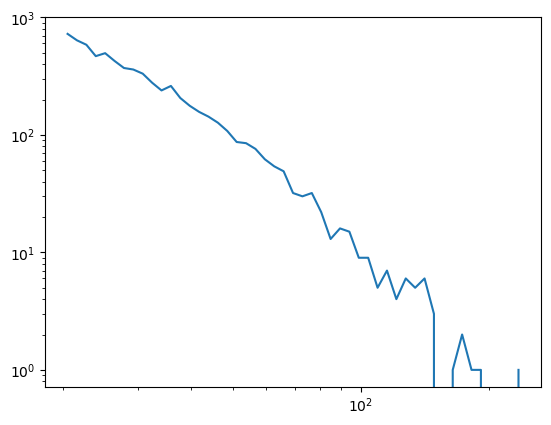

In [7]:
plt.figure()
plt.plot( rich_cents , n_clusters )
plt.xscale('log')
plt.yscale('log')

In [8]:
#des_lambda_bins = np.array( [ 20 , 30 , 45 , 60 , 240 ])
des_lambda_bins = np.array( [ 30 , 45 , 60 , 240 ])
des_z_bins = np.array( [ 0.2 , 0.35 , 0.5 , 0.65 ])

In [9]:
des_lambda_cent = ( des_lambda_bins[1:] + des_lambda_bins[:-1] )/2.
des_z_cent = ( des_z_bins[1:] + des_z_bins[:-1] )/2.

In [10]:
i = 0 
z_idx_0 = ( redmapper_catalogue['Z_LAMBDA'] < des_z_bins[i+1] ) & ( redmapper_catalogue['Z_LAMBDA'] > des_z_bins[i] )
i = 1 
z_idx_1 = ( redmapper_catalogue['Z_LAMBDA'] < des_z_bins[i+1] ) & ( redmapper_catalogue['Z_LAMBDA'] > des_z_bins[i] )
i = 2 
z_idx_2 = ( redmapper_catalogue['Z_LAMBDA'] < des_z_bins[i+1] ) & ( redmapper_catalogue['Z_LAMBDA'] > des_z_bins[i] )

In [11]:
n_clusters_0 , _  = np.histogram( redmapper_catalogue['LAMBDA'][ z_idx_0 ], bins = des_lambda_bins )
n_clusters_1 , _  = np.histogram( redmapper_catalogue['LAMBDA'][ z_idx_1 ], bins = des_lambda_bins )
n_clusters_2 , _  = np.histogram( redmapper_catalogue['LAMBDA'][ z_idx_2 ], bins = des_lambda_bins )

In [12]:
# Mean mass results, Table II DES Y1 cluster abundance results
# mwl_mean_0 = np.array( [ 14.036 , 14.323 , 14.454 , 14.758 ] )
# mwl_mean_1 = np.array( [ 14.007 , 14.291 , 14.488 , 14.744 ] )
# mwl_mean_2 = np.array( [ 13.929 , 14.301 , 14.493 , 14.724 ] )

mwl_mean_0 = np.array( [ 14.323 , 14.454 , 14.758 ] )
mwl_mean_1 = np.array( [ 14.291 , 14.488 , 14.744 ] )
mwl_mean_2 = np.array( [ 14.301 , 14.493 , 14.724 ] )

In [13]:
# Std for aMean mass results, Table II DES Y1 cluster abundance results
# mwl_std_0 = np.array( [ 0.032 + 0.045 , 0.031 + 0.051 , 0.044 + 0.050 , 0.038 + 0.052 ] )
# mwl_std_1 = np.array( [ 0.033 + 0.056 , 0.031 + 0.061 , 0.044 + 0.065 , 0.038 + 0.052 ] )
# mwl_std_2 = np.array( [ 0.048 + 0.072 , 0.041 + 0.086 , 0.056 + 0.068 , 0.061 + 0.069 ] )

mwl_std_0 = np.array( [ 0.031 + 0.051 , 0.044 + 0.050 , 0.038 + 0.052 ] )
mwl_std_1 = np.array( [ 0.031 + 0.061 , 0.044 + 0.065 , 0.038 + 0.052 ] )
mwl_std_2 = np.array( [ 0.041 + 0.086 , 0.056 + 0.068 , 0.061 + 0.069 ] )

(13.7, 15.0)

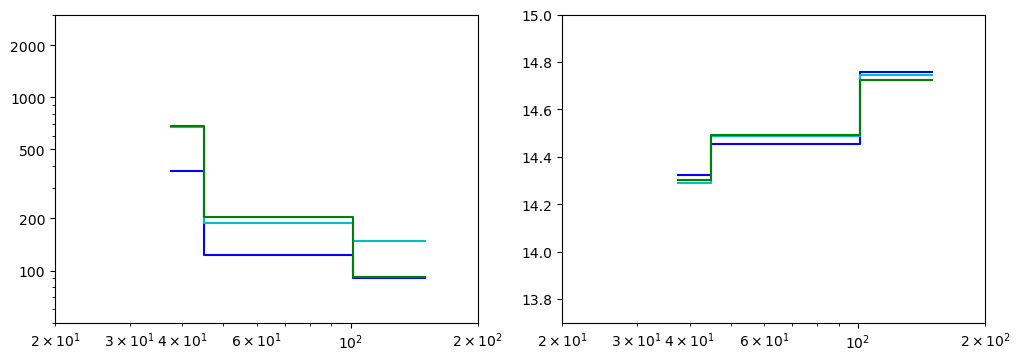

In [14]:
plt.figure( figsize = ( 12, 4 ))
plt.subplot(121)
plt.plot( des_lambda_cent , n_clusters_0 , 'b-' , drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , n_clusters_1 , 'c-' , drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , n_clusters_2 , 'g-' , drawstyle = 'steps-mid')
plt.xscale('log')
plt.yscale('log')
plt.yticks( [ 100 , 200 , 500 , 1000 , 2000 ], labels = [ 100 , 200 , 500 , 1000 , 2000 ])
plt.xlim( 20 , 200 )
plt.ylim( 50 , 3000 )

plt.subplot(122)
plt.plot( des_lambda_cent , mwl_mean_0 , 'b-' , drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , mwl_mean_1 , 'c-' , drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , mwl_mean_2 , 'g-' , drawstyle = 'steps-mid')
plt.xscale('log')
plt.xlim( 20 , 200 )
plt.ylim( 13.7 , 15 )

In [15]:
mwl_std = np.array( [ mwl_std_0, mwl_std_1, mwl_std_2 ] ).T

In [16]:
stacked_simulator = simulation.Universe_simulation( 'stacked_counts' ,
                                                    variable_params=['omega_m', 
                                                                     'sigma_8', 
                                                                     'alpha' , 
                                                                     'c' , 
                                                                     'sigma' , 
                                                                     'r' ],
                                                    fixed_params={'w_0': -1, 'w_a': 0 , 'beta':0} )
stacked_simulator.selection_richness = 0
stacked_simulator.dOmega = 1500/41253 * 4*np.pi
stacked_simulator.richness_bins = des_lambda_bins
stacked_simulator.redshift_bins = des_z_bins
stacked_simulator.sigma_mwl = 0.3
#stacked_simulator.dlog10m = 0.01
#stacked_simulator.log10ms = np.arange( 13.1, 15.5, stacked_simulator.dlog10m)
stacked_simulator.include_mwl_measurement_errors = True
stacked_simulator.mwl_std = mwl_std
stacked_simulator.correlation_mass_evolution = False
stacked_simulator.cme_mu_bins = np.linspace( np.log( 1e13/1e14 ) , np.log( 10**15.5 /1e14 ), 6  )
# stacked_simulator.hmf = ccl.hmf.MassFunc
# stacked_simulator = simulation.Universe_simulation( 'stacked_counts' ,
#                                                     variable_params=['omega_m', 'sigma_8'],
#                                                     fixed_params={'w_0': -1, 'w_a': 0} )

In [17]:
stacked_simulator.set_bins( z_bins = np.arange( 0.15 , 0.7 , 0.05 ) , m_bins=  np.arange( 13.1, 15.5, 0.01))

In [18]:
1500/41253

0.03636099192785979

In [19]:
no_r_stacked_simulator = simulation.Universe_simulation( 'stacked_counts' ,
                                                    variable_params=['omega_m', 'sigma_8', 'alpha' , 'c' , 'sigma' ],
                                                    fixed_params={'w_0': -1, 'w_a': 0 , 'r':0} )

no_r_stacked_simulator.dOmega = 1500/41253 * 4*np.pi
no_r_stacked_simulator.richness_bins = des_lambda_bins
no_r_stacked_simulator.redshift_bins = des_z_bins
no_r_stacked_simulator.z_bins = np.arange( 0.15 , 0.7 , 0.05 )
no_r_stacked_simulator.sigma_mwl = 0.3
no_r_stacked_simulator.log10ms = np.arange(13.1, 15.5, stacked_simulator.dlog10m)
no_r_stacked_simulator.include_mwl_measurement_errors = True
no_r_stacked_simulator.mwl_std = mwl_std
no_r_stacked_simulator.correlation_mass_evolution = False


In [20]:
stacked_simulator.available_params

{'omega_m': 0.3,
 'sigma_8': 0.8,
 'w_0': -1,
 'w_a': 0,
 'alpha': 0.8,
 'c': 3,
 'sigma': 0.3,
 'r': 0.0,
 'beta': 0,
 'c_rho': 0.0}

In [21]:
[0.1505880206823349,
 0.8029483258724213,
 0.6270101070404053,
 3.047786235809326,
 0.2592751234769821,
 0.3899948000907898]

[0.1505880206823349,
 0.8029483258724213,
 0.6270101070404053,
 3.047786235809326,
 0.2592751234769821,
 0.3899948000907898]

In [22]:
float(56.45234234234234)

56.45234234234234

In [24]:
stacked_simulator.richness_mass_relation = 'power-law'

In [25]:
sim_obs = stacked_simulator.run_simulation( torch.Tensor( [ 0.15 , 0.8 , 0.62 , 3.04 , 0.25 , 0.1 , 0 ] )  )

In [58]:
sim_n_clusters = sim_obs[:12].reshape( 4 , 3 )
sim_mwl_mean = sim_obs[12:].reshape( 4 , 3 )

sim_n_clusters_0 = sim_n_clusters.T[0]
sim_n_clusters_1 = sim_n_clusters.T[1]
sim_n_clusters_2 = sim_n_clusters.T[2]

sim_mwl_mean_0 = sim_mwl_mean.T[0]
sim_mwl_mean_1 = sim_mwl_mean.T[1]
sim_mwl_mean_2 = sim_mwl_mean.T[2]

In [59]:
old_sim_obs = no_r_stacked_simulator.run_simulation( torch.Tensor( [ 0.15 , 0.8 , 0.62 , 3.04 , 0.25 , 0. ] )  )

In [60]:
old_sim_n_clusters = old_sim_obs[:12].reshape( 4 , 3 )
old_sim_mwl_mean = old_sim_obs[12:].reshape( 4 , 3 )

old_sim_n_clusters_0 = old_sim_n_clusters.T[0]
old_sim_n_clusters_1 = old_sim_n_clusters.T[1]
old_sim_n_clusters_2 = old_sim_n_clusters.T[2]

old_sim_mwl_mean_0 = old_sim_mwl_mean.T[0]
old_sim_mwl_mean_1 = old_sim_mwl_mean.T[1]
old_sim_mwl_mean_2 = old_sim_mwl_mean.T[2]

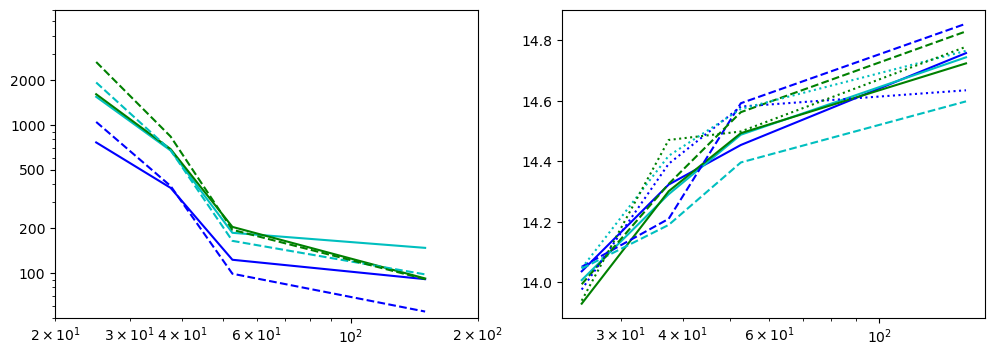

In [ ]:
plt.figure( figsize = ( 12, 4 ))
plt.subplot(121)
plt.plot( des_lambda_cent , n_clusters_0 , 'b-' ) #, drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , n_clusters_1 , 'c-' ) #, drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , n_clusters_2 , 'g-' ) #, drawstyle = 'steps-mid')

plt.plot( des_lambda_cent , sim_n_clusters_0 , 'b--' ) #, drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , sim_n_clusters_1 , 'c--' ) #, drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , sim_n_clusters_2 , 'g--' ) #, drawstyle = 'steps-mid')

# plt.plot( des_lambda_cent , old_sim_n_clusters_0 , 'b:' ) #, drawstyle = 'steps-mid')
# plt.plot( des_lambda_cent , old_sim_n_clusters_1 , 'c:' ) #, drawstyle = 'steps-mid')
# plt.plot( des_lambda_cent , old_sim_n_clusters_2 , 'g:' ) #, drawstyle = 'steps-mid')
plt.xscale('log')
plt.yscale('log')
plt.yticks( [ 100 , 200 , 500 , 1000 , 2000 ], labels = [ 100 , 200 , 500 , 1000 , 2000 ])
plt.xlim( 20 , 200 )
plt.ylim( 50 , 6000 )

plt.subplot(122)
plt.plot( des_lambda_cent , mwl_mean_0 , 'b-' ) #, drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , mwl_mean_1 , 'c-' ) #, drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , mwl_mean_2 , 'g-' ) #, drawstyle = 'steps-mid')

plt.plot( des_lambda_cent , sim_mwl_mean_0 , 'b--' ) #, drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , sim_mwl_mean_1 , 'c--' ) #, drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , sim_mwl_mean_2 , 'g--' ) #, drawstyle = 'steps-mid')

plt.plot( des_lambda_cent , old_sim_mwl_mean_0 , 'b:' ) #, drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , old_sim_mwl_mean_1 , 'c:' ) #, drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , old_sim_mwl_mean_2 , 'g:' ) #, drawstyle = 'steps-mid')
plt.xscale('log')
# plt.xlim( 20 , 200 )
# plt.ylim( 13.7 , 15 )

In [ ]:
# mean_params = [0.5647695064544678,
#  0.7186958491802216,
#  1.8720948100090027,
#  1.8384299874305725,
#  0.4349806308746338]

In [63]:
sim_obs = stacked_simulator.run_simulation( torch.Tensor( [0.17871107906103134,
                                                         0.693568229675293,
                                                         0.967983686923981,
                                                         3.040264844894409,
                                                          0.24637287110090256,
                                                         0.3546264320611954 , 0 ] )  )

In [64]:
sim_n_clusters = sim_obs[:12].reshape( 4 , 3 )
sim_mwl_mean = sim_obs[12:].reshape( 4 , 3 )

sim_n_clusters_0 = sim_n_clusters.T[0]
sim_n_clusters_1 = sim_n_clusters.T[1]
sim_n_clusters_2 = sim_n_clusters.T[2]

sim_mwl_mean_0 = sim_mwl_mean.T[0]
sim_mwl_mean_1 = sim_mwl_mean.T[1]
sim_mwl_mean_2 = sim_mwl_mean.T[2]

In [65]:
# Assuming the arrays are already of the same shape and are 2D
n_clusters = np.array( [ n_clusters_0, n_clusters_1, n_clusters_2 ]).T
mwl_mean = np.array( [ mwl_mean_0, mwl_mean_1, mwl_mean_2 ] ).T

# Flatten both stacks and concatenate them to match the format of the `stacked_counts` result
des_stacked_results = np.vstack( np.array( [ n_clusters, mwl_mean ] ) ).flatten()  

In [66]:
sim_n_clusters = des_stacked_results[:12].reshape( 4 , 3 )
sim_mwl_mean = des_stacked_results[12:].reshape( 4 , 3 )

alt_sim_n_clusters_0 = sim_n_clusters.T[0]
alt_sim_n_clusters_1 = sim_n_clusters.T[1]
alt_sim_n_clusters_2 = sim_n_clusters.T[2]

alt_sim_mwl_mean_0 = sim_mwl_mean.T[0]
alt_sim_mwl_mean_1 = sim_mwl_mean.T[1]
alt_sim_mwl_mean_2 = sim_mwl_mean.T[2]

In [67]:
[0.17871107906103134,
 0.693568229675293,
 0.5567983686923981,
 3.040264844894409,
 0.24637287110090256,
 0.3546264320611954]

[0.17871107906103134,
 0.693568229675293,
 0.5567983686923981,
 3.040264844894409,
 0.24637287110090256,
 0.3546264320611954]

In [68]:
sim_obs = stacked_simulator.run_simulation( torch.Tensor( [ 0.187871107906103134,
                                                            0.753568229675293,
                                                            1/1.3,
                                                            3.040264844894409,
                                                            0.14637287110090256,
                                                            0.0 , 0 ] )  )

In [69]:
# sim_obs = stacked_simulator.run_simulation( torch.Tensor( mean_params )  )

In [70]:
1/1.3

0.7692307692307692

In [71]:
# Number of simulations to run
n_simulations = 10

# Collect results
sim_n_clusters_0_list = []
sim_n_clusters_1_list = []
sim_n_clusters_2_list = []

sim_mwl_mean_0_list = []
sim_mwl_mean_1_list = []
sim_mwl_mean_2_list = []

# Run multiple simulations and collect the outputs
for _ in range(n_simulations):
    sim_obs = stacked_simulator.run_simulation( torch.Tensor( [ 0.15 , 0.85 , 0.62 , 3.04 , 0.25 , 0. , 0  ] ))

    sim_n_clusters = sim_obs[:12].reshape(4, 3)
    sim_mwl_mean = sim_obs[12:].reshape(4, 3)

    # Extract values
    sim_n_clusters_0_list.append(sim_n_clusters.T[0])
    sim_n_clusters_1_list.append(sim_n_clusters.T[1])
    sim_n_clusters_2_list.append(sim_n_clusters.T[2])

    sim_mwl_mean_0_list.append(sim_mwl_mean.T[0])
    sim_mwl_mean_1_list.append(sim_mwl_mean.T[1])
    sim_mwl_mean_2_list.append(sim_mwl_mean.T[2])

# Convert lists to numpy arrays
sim_n_clusters_0_array = np.array(sim_n_clusters_0_list)
sim_n_clusters_1_array = np.array(sim_n_clusters_1_list)
sim_n_clusters_2_array = np.array(sim_n_clusters_2_list)

sim_mwl_mean_0_array = np.array(sim_mwl_mean_0_list)
sim_mwl_mean_1_array = np.array(sim_mwl_mean_1_list)
sim_mwl_mean_2_array = np.array(sim_mwl_mean_2_list)

# Compute standard deviations
std_n_clusters_0 = np.std(sim_n_clusters_0_array, axis=0)
std_n_clusters_1 = np.std(sim_n_clusters_1_array, axis=0)
std_n_clusters_2 = np.std(sim_n_clusters_2_array, axis=0)

std_mwl_mean_0 = np.std(sim_mwl_mean_0_array, axis=0)
std_mwl_mean_1 = np.std(sim_mwl_mean_1_array, axis=0)
std_mwl_mean_2 = np.std(sim_mwl_mean_2_array, axis=0)

# Print results
print("Standard Deviations for n_clusters_0:", std_n_clusters_0 )
print("Standard Deviations for n_clusters_1:", std_n_clusters_1 )
print("Standard Deviations for n_clusters_2:", std_n_clusters_2 )

Standard Deviations for n_clusters_0: [37.98736632 19.23668371  5.08330601  8.7298339 ]
Standard Deviations for n_clusters_1: [27.95156525 29.07043171 18.46618531  9.30644938]
Standard Deviations for n_clusters_2: [61.67365726 31.12057197 18.82790482 11.07293999]


In [72]:
print("Standard Deviations for mwl_mean_clusters_0:", std_mwl_mean_0)
print("Standard Deviations for mwl_mean_clusters_1:", std_mwl_mean_1)
print("Standard Deviations for mwl_mean_clusters_2:", std_mwl_mean_2)

Standard Deviations for mwl_mean_clusters_0: [0.05301231 0.08763194 0.07101975 0.11588837]
Standard Deviations for mwl_mean_clusters_1: [0.10842049 0.12100212 0.10083485 0.10258552]
Standard Deviations for mwl_mean_clusters_2: [0.13294716 0.12055971 0.08403764 0.11083765]


In [73]:
mwl_std.T

array([[0.077, 0.082, 0.094, 0.09 ],
       [0.089, 0.092, 0.109, 0.09 ],
       [0.12 , 0.127, 0.124, 0.13 ]])

In [74]:
sim_n_clusters_0_mean = np.mean( sim_n_clusters_0_array , axis = 0 )
sim_n_clusters_1_mean = np.mean( sim_n_clusters_1_array , axis = 0 )
sim_n_clusters_2_mean = np.mean( sim_n_clusters_2_array , axis = 0 )

sim_mwl_mean_0_mean = np.mean( sim_mwl_mean_0_array , axis = 0 )
sim_mwl_mean_1_mean = np.mean( sim_mwl_mean_1_array , axis = 0 )
sim_mwl_mean_2_mean = np.mean( sim_mwl_mean_2_array , axis = 0 )

In [ ]:
# chi2 
chi2 = np.sum( ( ( n_clusters_0 - sim_n_clusters_0_mean ) / std_n_clusters_0 )**2 + 
        ( ( n_clusters_1 - sim_n_clusters_1_mean ) / std_n_clusters_1 )**2 +
        ( ( n_clusters_2 - sim_n_clusters_2_mean ) / std_n_clusters_2 )**2 + 
        ( ( mwl_mean_0 - sim_mwl_mean_0_mean ) / std_mwl_mean_0 )**2 +
        ( ( mwl_mean_1 - sim_mwl_mean_1_mean ) / std_mwl_mean_1 )**2 +
        ( ( mwl_mean_2 - sim_mwl_mean_2_mean ) / std_mwl_mean_2 )**2 ) 
chi2

In [75]:
chi2 / ( 4 * 3 * 2 - 4 )

68.8146190267319

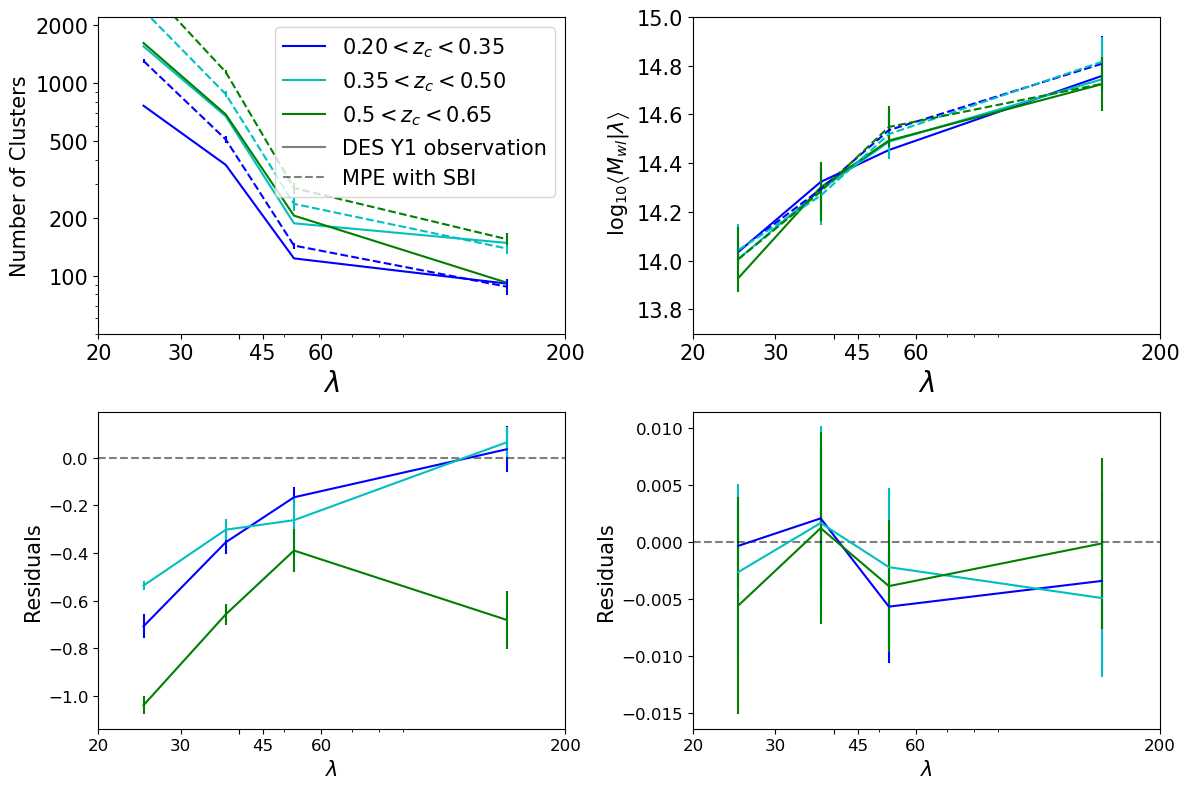

In [ ]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Subplot 1: Number of clusters
plt.subplot(221)
plt.plot(des_lambda_cent, n_clusters_0, 'b-', label='$ 0.20 < z_c < 0.35 $')
plt.plot(des_lambda_cent, n_clusters_1, 'c-', label='$ 0.35 < z_c < 0.50 $')
plt.plot(des_lambda_cent, n_clusters_2, 'g-', label='$ 0.5 < z_c < 0.65$')

plt.errorbar(des_lambda_cent, sim_n_clusters_0_mean, fmt='b--' , yerr=std_n_clusters_0 )
plt.errorbar(des_lambda_cent, sim_n_clusters_1_mean, fmt='c--' , yerr=std_n_clusters_1 )
plt.errorbar(des_lambda_cent, sim_n_clusters_2_mean, fmt='g--' , yerr=std_n_clusters_2 )

plt.plot( 0 , 0 , 'k-', alpha = 0.5 , label ='DES Y1 observation')
plt.plot( 0 , 0 , 'k--', alpha = 0.5 , label ='MPE with SBI')

plt.xscale('log')
plt.yscale('log')
plt.yticks([100, 200, 500, 1000, 2000], labels=[100, 200, 500, 1000, 2000])
plt.xlim(20, 200)
plt.ylim(50, 2200)
plt.xlabel(r'$\lambda$' , fontsize = 20)
plt.ylabel('Number of Clusters' , fontsize = 15)
plt.legend(loc='upper right' , fontsize = 15 )
plt.xticks( ticks = [ 20 , 30 , 40 , 45 , 60 , 200 ],
            labels = [ 20 , 30 , None , 45 , 60 , 200 ] , fontsize = 15 )
plt.yticks( fontsize = 15 )

# Subplot 2: Mean MWL
plt.subplot(222)
plt.plot(des_lambda_cent, mwl_mean_0, 'b-' )
plt.plot(des_lambda_cent, mwl_mean_1, 'c-' )
plt.plot(des_lambda_cent, mwl_mean_2, 'g-' )

plt.errorbar(des_lambda_cent, sim_mwl_mean_0_mean, fmt='b--' , yerr=std_mwl_mean_0 )
plt.errorbar(des_lambda_cent, sim_mwl_mean_1_mean, fmt='c--' , yerr=std_mwl_mean_1 )
plt.errorbar(des_lambda_cent, sim_mwl_mean_2_mean, fmt='g--' , yerr=std_mwl_mean_2 )

plt.xscale('log')
plt.xlim(20, 200)
plt.ylim(13.7, 15)
plt.xlabel(r'$\lambda$' , fontsize = 20)
plt.ylabel(r' log$_{10} \left< M_{wl} | \lambda \right>$' , fontsize = 15)
plt.xticks( ticks = [ 20 , 30 , 40 , 45 , 60 , 200 ],
            labels = [ 20 , 30 , None , 45 , 60 , 200 ] , fontsize = 15 )
plt.yticks( fontsize = 15 )

# Subplot 3: Residuals for number of clusters
plt.subplot(223)
residual_clusters_0 = n_clusters_0 - sim_n_clusters_0_mean
residual_clusters_1 = n_clusters_1 - sim_n_clusters_1_mean
residual_clusters_2 = n_clusters_2 - sim_n_clusters_2_mean

plt.errorbar(des_lambda_cent, residual_clusters_0 / n_clusters_0 , yerr=std_n_clusters_0 / n_clusters_0, fmt='b-', label='$ 0.20 < z_c < 0.35 $ Residuals')
plt.errorbar(des_lambda_cent, residual_clusters_1 / n_clusters_1 , yerr=std_n_clusters_1 / n_clusters_1, fmt='c-', label='$ 0.35 < z_c < 0.50 $ Residuals')
plt.errorbar(des_lambda_cent, residual_clusters_2 / n_clusters_2 , yerr=std_n_clusters_2 / n_clusters_2, fmt='g-', label='$ 0.5 < z_c < 0.65 $ Residuals')

plt.axhline(0, color='k', linestyle='--', alpha=0.5)
plt.xscale('log')
plt.xlim(20, 200)
plt.xlabel(r'$\lambda$', fontsize=15)
plt.ylabel('Residuals', fontsize=15)
plt.xticks( ticks = [ 20 , 30 , 40 , 45 , 60 , 200 ],
            labels = [ 20 , 30 , None , 45 , 60 , 200 ] , fontsize = 12 )
plt.yticks( fontsize = 12 )

# Subplot 4: Residuals for MWL
plt.subplot(224)
residual_mwl_0 = mwl_mean_0 - sim_mwl_mean_0_mean
residual_mwl_1 = mwl_mean_1 - sim_mwl_mean_1_mean
residual_mwl_2 = mwl_mean_2 - sim_mwl_mean_2_mean

plt.errorbar( des_lambda_cent, 
              residual_mwl_0 / mwl_mean_0, 
              yerr=std_mwl_mean_0 / mwl_mean_0 , fmt='b-', label='$ 0.20 < z_c < 0.35 $ Residuals')
plt.errorbar( des_lambda_cent, 
              residual_mwl_1 / mwl_mean_1, 
              yerr=std_mwl_mean_1 / mwl_mean_1 , fmt='c-', label='$ 0.35 < z_c < 0.50 $ Residuals')
plt.errorbar( des_lambda_cent, 
              residual_mwl_2 / mwl_mean_2, 
              yerr=std_mwl_mean_2 / mwl_mean_2 , fmt='g-', label='$ 0.5 < z_c < 0.65 $ Residuals')

plt.axhline(0, color='k', linestyle='--', alpha=0.5)
plt.xscale('log')
plt.xlim(20, 200)
plt.xlabel(r'$\lambda$', fontsize=15)
plt.ylabel('Residuals', fontsize=15)
plt.xticks( ticks = [ 20 , 30 , 40 , 45 , 60 , 200 ],
            labels = [ 20 , 30 , None , 45 , 60 , 200 ] , fontsize = 12 )
plt.yticks( fontsize = 12 )

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()
# plt.savefig('temp.png')

Should be able to turn this around to see DES Y1 Figure 8. 

- run a simulation
- look at P(detection) as a function of mass
- loom at sigma( lambda( M) )

In [79]:
# Om0, sigma8, w0 , wa, alpha_l , c_l , sigma_l, r, beta, c_rho

In [88]:
stacked_simulator.selection_richness = 0

In [264]:
stacked_simulator.dOmega

0.45692570047120834

In [314]:
stacked_simulator.dOmega = 4*np.pi 

full_parameter_set = stacked_simulator._get_parameter_set( torch.Tensor( [ 0.15 , 0.85 , 0.62 , 3.04 , 0.3 , 0. , 0  ] ) )
sim_richness, sim_log10M_wl, sim_z_clusters, sim_mu_clusters = stacked_simulator._run_simulation( full_parameter_set )

stacked_simulator.dOmega = 0.45692570047120834

In [315]:
full_parameter_set

[0.15000000596046448,
 0.8500000238418579,
 -1,
 0,
 0.6200000047683716,
 3.0399999618530273,
 0.30000001192092896,
 0.0,
 0,
 0.0]

In [316]:
np.min( redmapper_catalogue['Z_LAMBDA']), np.max( redmapper_catalogue['Z_LAMBDA']) , np.min( redmapper_catalogue['LAMBDA']), np.max( redmapper_catalogue['LAMBDA'])

(0.20000643, 0.85766494, 20.003485, 234.50368)

In [317]:
np.min( sim_richness ), np.max( sim_richness )

(1.397349499922049, 258.36187135986535)

In [318]:
len( sim_richness ), len( sim_richness[ ( sim_richness > 20 ) & ( sim_z_clusters > 0.2 ) * ( sim_z_clusters < 0.857 ) ])

(1756994, 53047)

In [319]:
log10_m200_bins = np.linspace( 13 , 15.2 , 50 )
log10_m200_cents = ( log10_m200_bins[1:] + log10_m200_bins[:-1] )/2.

In [320]:
log10_m_true_all_no_z = np.log10( np.exp( sim_mu_clusters) * 1e14 )

In [321]:
log10_m_true_sel = np.log10( np.exp( sim_mu_clusters[ ( sim_richness > 20 ) & ( sim_z_clusters > 0.2 ) & ( sim_z_clusters < 0.857 ) ] ) * 1e14 )
log10_m_true_all = np.log10( np.exp( sim_mu_clusters[ ( sim_z_clusters > 0.2 ) & ( sim_z_clusters < 0.857 ) ] ) * 1e14 )

In [322]:
mean_rich , _ , _ = stats.binned_statistic( log10_m_true_all ,  
                                           sim_richness[ ( sim_z_clusters > 0.2 ) * ( sim_z_clusters < 0.857 ) ]  , 
                                           statistic = np.mean,
                                           bins = log10_m200_bins )


In [323]:
var_rich , _ , _ = stats.binned_statistic( log10_m_true_all ,  
                                           sim_richness[ ( sim_z_clusters > 0.2 ) * ( sim_z_clusters < 0.857 ) ]  , 
                                           statistic = np.var,
                                           bins = log10_m200_bins )

# count_rich , _ , _ = stats.binned_statistic( log10_m_true_sel ,  
#                                            sim_richness[ ( sim_z_clusters > 0.2 ) * ( sim_z_clusters < 0.857 ) ]  , 
#                                            statistic = np.var,
#                                            bins = log10_m200_bins )

In [324]:
all_counts, _ = np.histogram( log10_m_true_all , bins = log10_m200_bins )
sel_counts, _ = np.histogram( log10_m_true_sel , bins = log10_m200_bins )

In [325]:
# the DES analysis find val_50 = 14.09
val_50 = log10_m200_cents[np.argmin( np.abs( sel_counts / all_counts - 0.5 ) )]
val_50

13.965306122448979

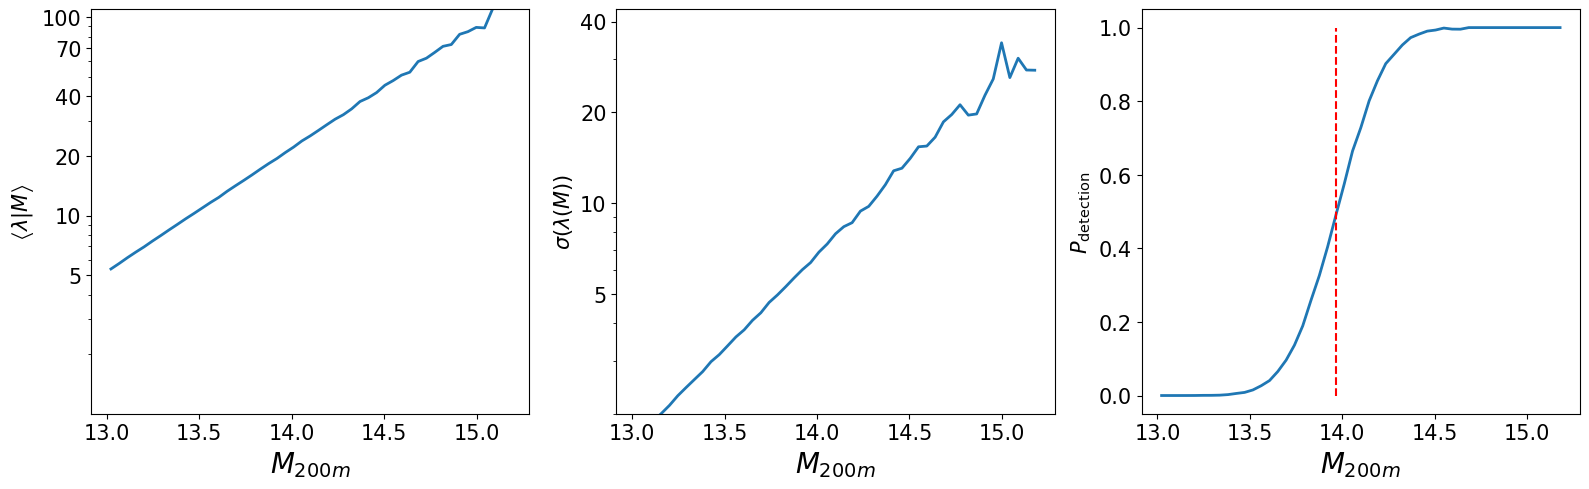

In [326]:
plt.figure( figsize = ( 16 , 5 ))
plt.subplot( 131 )
plt.plot( log10_m200_cents , mean_rich , lw = 2  )
plt.xlabel(r'$M_{200m}$' , fontsize = 20)
plt.ylabel(r'$\left< \lambda | M \right>$' , fontsize = 15)
plt.yscale('log')
plt.ylim( 1 , 110 )
plt.xticks( fontsize = 15 )
plt.yticks( ticks = [ 5 , 10 , 20 , 40 , 70 , 100  ],
            labels = [ 5 , 10 , 20 , 40 , 70 , 100  ] , fontsize = 15 )

plt.subplot( 132 )
plt.plot( log10_m200_cents , var_rich**0.5 , lw = 2  )
plt.xlabel(r'$M_{200m}$' , fontsize = 20)
plt.ylabel(r'$\sigma( \lambda( M ))$' , fontsize = 15)
plt.yscale('log')
plt.xticks( fontsize = 15 )
plt.yticks( ticks = [ 5 , 10 , 20 , 40 ],
            labels = [ 5 , 10 , 20 , 40 ] , fontsize = 15 )
plt.ylim(  2 , 44 )

plt.subplot( 133 )
plt.plot( log10_m200_cents , sel_counts / all_counts , lw = 2  )
plt.plot( [ val_50 , val_50 ] , [ 0 , 1 ] , 'r--' )
plt.xlabel(r'$M_{200m}$' , fontsize = 20)
plt.ylabel(r'$P_{\rm{detection}}$' , fontsize = 15)
plt.xticks( fontsize = 15 )
plt.yticks( fontsize = 15 )
plt.tight_layout()

In [346]:
#log10_m200_bins = np.linspace( 13.05 , 15.2 , 120 )
log10_m200_bins = np.arange( 13.05 , 15.2 , 0.05 )
log10_m200_cents = ( log10_m200_bins[1:] + log10_m200_bins[:-1] )/2.

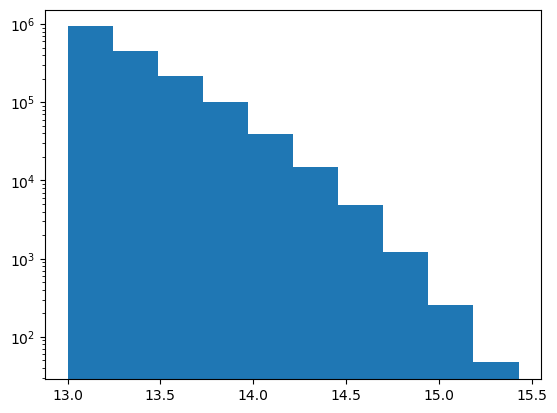

In [351]:
plt.hist( log10_m_true_all_no_z )
plt.yscale('log')

In [347]:
richness_filter_0 = ( sim_richness < 10 ) & ( sim_z_clusters > 0.2 ) & ( sim_z_clusters < 0.857 ) 
richness_filter_1 = ( sim_richness < 20 ) & ( sim_richness > 10 ) & ( sim_z_clusters > 0.2 ) & ( sim_z_clusters < 0.857 ) 
richness_filter_2 = ( sim_richness < 30 ) & ( sim_richness > 20 ) & ( sim_z_clusters > 0.2 ) & ( sim_z_clusters < 0.857 ) 
richness_filter_3 = ( sim_richness < 40 ) & ( sim_richness > 30 ) & ( sim_z_clusters > 0.2 ) & ( sim_z_clusters < 0.857 ) 
richness_filter_4 = ( sim_richness < 50 ) & ( sim_richness > 40 ) & ( sim_z_clusters > 0.2 ) & ( sim_z_clusters < 0.857 ) 
richness_filter_5 = ( sim_richness > 50 ) & ( sim_z_clusters > 0.2 ) & ( sim_z_clusters < 0.857 ) 

labels_lambda = [r' $\lambda_{\rm{pmem}}$ < 10 ',
          r'10 <  $\lambda_{\rm{pmem}}$ < 20',
          r'20 <  $\lambda_{\rm{pmem}}$ < 30',
          r'30 <  $\lambda_{\rm{pmem}}$ < 40',
          r'40 <  $\lambda_{\rm{pmem}}$ < 50',
          r'50 <  $\lambda_{\rm{pmem}}$' ]


print( len( sim_richness[richness_filter_0] ))
print( len( sim_richness[richness_filter_1] ))
print( len( sim_richness[richness_filter_2] ))
print( len( sim_richness[richness_filter_3] ))
print( len( sim_richness[richness_filter_4] ))
print( len( sim_richness[richness_filter_5] ))

log10m_bins = np.linspace( 13 , 15.5 , 30 )
log10m_cents = ( log10m_bins[1:] + log10m_bins[:-1] )/2.

count_pzwav_pure_80_mis_mf0 , _ = np.histogram( log10_m_true_all_no_z[richness_filter_0] , bins = log10_m200_bins )
count_pzwav_pure_80_mis_mf1 , _ = np.histogram( log10_m_true_all_no_z[richness_filter_1] , bins = log10_m200_bins )
count_pzwav_pure_80_mis_mf2 , _ = np.histogram( log10_m_true_all_no_z[richness_filter_2] , bins = log10_m200_bins )
count_pzwav_pure_80_mis_mf3 , _ = np.histogram( log10_m_true_all_no_z[richness_filter_3] , bins = log10_m200_bins )
count_pzwav_pure_80_mis_mf4 , _ = np.histogram( log10_m_true_all_no_z[richness_filter_4] , bins = log10_m200_bins )
count_pzwav_pure_80_mis_mf5 , _ = np.histogram( log10_m_true_all_no_z[richness_filter_5] , bins = log10_m200_bins )

count_m = [ count_pzwav_pure_80_mis_mf0,
               count_pzwav_pure_80_mis_mf1,
               count_pzwav_pure_80_mis_mf2,
               count_pzwav_pure_80_mis_mf3,
               count_pzwav_pure_80_mis_mf4,
               count_pzwav_pure_80_mis_mf5 ]


686584
215791
35474
10385
3726
3462


/tmp/ipykernel_7283/920521021.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('coolwarm')


(13.0, 15.0)

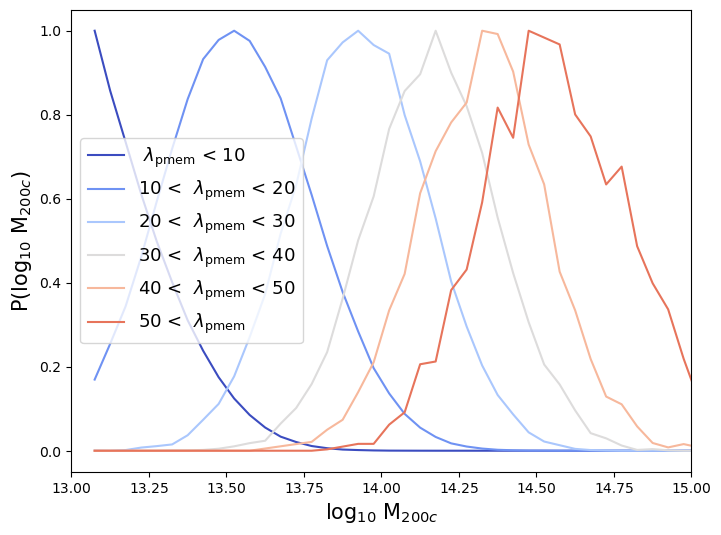

In [348]:
plt.figure( figsize = ( 8 , 6 ) )

# Use a colormap that goes from blue to red
cmap = get_cmap('coolwarm')

for i in range(len(count_m)):
    color = cmap(i / len(count_m))  # Get the color from the colormap
    plt.plot( log10_m200_cents , count_m[i] / np.max(count_m[i]), label=labels_lambda[i], color=color )
    plt.legend(fontsize=13)
    
plt.xlabel(r'log$_{10}$ M$_{200c}$' , fontsize = 15 )
plt.ylabel(r'P(log$_{10}$ M$_{200c})$' , fontsize = 15 )
plt.xlim( 13, 15 )

In [46]:
class CustomPrior(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Define uniform priors for the parameters
        self.prior_uniform =  utils.BoxUniform( 
                          low = [ 0.05 , 0.5 , -3 , -2 , 0 , 1 , 0.05, -1  ] , 
                          high = [ 1.0 , 1.3 , -0.1 , 2 , 2 , 5 , 1 , 1 ] )
    
    def log_prob(self, x):
        # Check the constraint w0 + wa < 0
        w0_plus_wa = x[..., 2] + x[..., 3]  # assuming w0 is at index 2 and wa at index 3
        mask = ( w0_plus_wa < 0 )
        return torch.where( mask, self.prior_uniform.log_prob(x), torch.tensor(-float('inf')))
    
    def sample(self, sample_shape=torch.Size()):
        if len(sample_shape) == 0:
            sample_shape = torch.Size([1])  # Default to a single sample if sample_shape is empty
            
        samples = []
        while len(samples) < sample_shape[0]:
            sample = self.prior_uniform.sample((1,))
            if (sample[..., 2] + sample[..., 3]).lt(0):  # Ensure w0 + wa < 0
                samples.append(sample)
                
        return torch.cat(samples, dim=0)

# Instantiate the custom prior
w0_plus_wa_positive_prior = CustomPrior()

In [168]:
prior = utils.BoxUniform( low = [ 0.05 , 0.5  , 0 , 1 , 0.05, -1 , -1  ] , 
                          high = [ 1.0 , 1.5 , 2 , 5 , 1 , 1 , 1 ] )

In [ ]:
# infer posteriors
des_posterior = infer( stacked_simulator.run_simulation , 
                       prior, 
                       method = "SNPE", 
                       num_simulations = 60000 , 
                       num_workers = 40 )

Running 60000 simulations in 60000 batches.:  22%|██▏       | 13197/60000 [1:01:28<2:17:14,  5.68it/s]

In [ ]:
with open('/sps/euclid/Users/cmurray/clusters_likelihood/des_posterior.pkl', "wb") as handle:
    pickle.dump( des_posterior, handle)

In [ ]:
with open('/sps/euclid/Users/cmurray/clusters_likelihood/des_posterior.pkl', 'rb') as file:
    des_posterior = pickle.load(file)

In [ ]:
# # infer posteriors
# old_des_posterior = infer( old_stacked_simulator.run_simulation , 
#                        prior, 
#                        method = "SNPE", 
#                        num_simulations = 10000 , 
#                        num_workers = 40 )

In [ ]:
no_r_prior = utils.BoxUniform( low = [ 0.05 , 0.5  , 0 , 1 , 0.05 ] , 
                          high = [ 1.0 , 1.5 , 2 , 5 , 1 ] )

In [251]:
no_r_des_posterior = infer( no_r_stacked_simulator.run_simulation , 
                           no_r_prior, 
                           method = "SNPE", 
                           num_simulations = 60000 , 
                           num_workers = 40 )

Running 60000 simulations in 60000 batches.: 100%|██████████| 60000/60000 [4:22:19<00:00,  3.81it/s]


 Neural network successfully converged after 159 epochs.

In [252]:
with open('/sps/euclid/Users/cmurray/clusters_likelihood/no_r_des_posterior.pkl', "wb") as handle:
    pickle.dump( no_r_des_posterior, handle)

In [253]:
with open('/sps/euclid/Users/cmurray/clusters_likelihood/no_r_des_posterior.pkl', 'rb') as file:
    no_r_des_posterior = pickle.load(file)

In [ ]:
# Assuming the arrays are already of the same shape and are 2D
n_clusters = np.array( [ n_clusters_0, n_clusters_1, n_clusters_2 ]).T
mwl_mean = np.array( [ mwl_mean_0, mwl_mean_1, mwl_mean_2 ] ).T

# Flatten both stacks and concatenate them to match the format of the `stacked_counts` result
des_stacked_results = np.vstack( np.array( [ n_clusters, mwl_mean ] ) ).flatten()  

In [254]:
nsamples = 100000
samples_des_y1 = des_posterior.sample( (nsamples,), x = des_stacked_results )

Drawing 100000 posterior samples: 100063it [00:01, 74711.57it/s]                           


In [255]:
# nsamples = 100000
# old_samples_des_y1 = old_des_posterior.sample( (nsamples,), x = des_stacked_results )

In [256]:
nsamples = 1000000
no_r_samples_des_y1 = no_r_des_posterior.sample( (nsamples,), x = des_stacked_results )

Drawing 1000000 posterior samples: 1002917it [00:08, 122380.10it/s]                            


In [257]:
from IPython.display import display, Math

#labels_math = ['\Omega_m' , '\sigma_8' , 'w_0' , 'w_a' , r'\alpha_{\lambda}' , '\sigma_{\lambda}' , 'c_{\lambda}']
labels_math = ['\Omega_m' , '\sigma_8'  , r'\alpha_{\lambda}' , 'c_{\lambda}' , '\sigma_{\lambda}'  , r'\rho' , r'c_{\rho}']

mean_params = []
median_params = []
for i in range( len( labels_math )):
    mcmc = np.percentile( samples_des_y1.numpy() [:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_math[i])
    display(Math(txt))
    
    mean_params.append( mcmc[1] )
    median_params.append( np.median( mcmc[1]) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [258]:
from IPython.display import display, Math

#labels_math = ['\Omega_m' , '\sigma_8' , 'w_0' , 'w_a' , r'\alpha_{\lambda}' , '\sigma_{\lambda}' , 'c_{\lambda}']
labels_math = ['\Omega_m' , '\sigma_8'  , r'\alpha_{\lambda}' , 'c_{\lambda}' , '\sigma_{\lambda}' ]# , r'\rho']

mean_params = []
median_params = []
for i in range( len( labels_math )):
    mcmc = np.percentile( no_r_samples_des_y1.numpy() [:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_math[i])
    display(Math(txt))
    
    mean_params.append( mcmc[1] )
    median_params.append( np.median( mcmc[1]) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [136]:
# samples_des_y1 = des_posterior.sample( (nsamples,), x = sim_obs )

\begin{equation}
\left< M_l | \lambda , z \right> \frac{1}{N} \int dz d\lambda P( \lambda | m , z ) M
\end{equation}

mais ce masse moyenne vient de stacked shear, alors 

\begin{equation}
\left< \Delta \Sigma | {M_i} \right> \rightarrow \left< M \right>
\end{equation}

par contre

\begin{equation}
\Delta \Sigma(M) \propto r_{vir} \propto M^{1/3}
\end{equation}

donc le masse moyenne que on 'infer' de stacked weak lensing sera plutot,

\begin{equation}
\left< M_l | \lambda , z \right> \frac{1}{N} \int dz d\lambda P( \lambda | m , z ) M^{1/3}
\end{equation}

In [56]:
samples_sliced.shape

NameError: name 'samples_sliced' is not defined

In [57]:
samples_des_y1.numpy().shape

(100000, 6)

In [145]:
alt_samples_des_y1.numpy().shape

(1000000, 5)

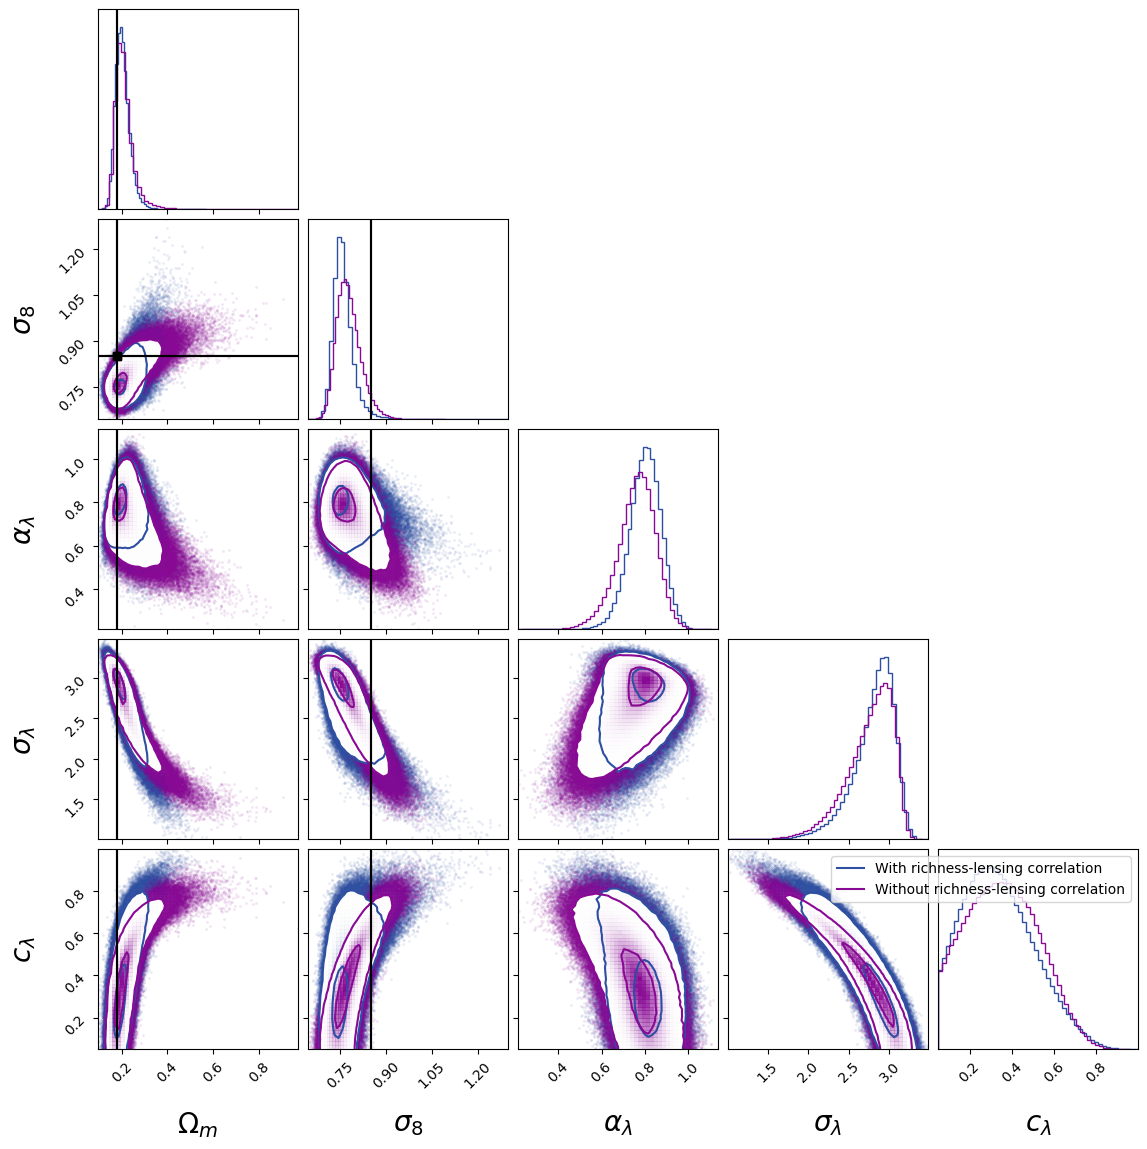

In [148]:
# Updated labels and limits for 5D plot (since alt_samples has 5 dimensions)
labels_5d = ['$\Omega_m$', '$\sigma_8$', r'$\alpha_{\lambda}$', r'$\sigma_{\lambda}$', r'$c_{\lambda}$' ]#, 'r']
truths_5d = [0.18, 0.85, None, None, None ]

# Slice the 6D samples to 5D to match alt_samples
samples_sliced = samples_des_y1.numpy()[:, :5]  # Selecting the first 5 dimensions

# Create the corner plot for samples (now 5D)
figure = corner.corner(samples_sliced, 
                       levels=[0.393, 0.98],  
                       bins=50, 
                       hist_kwargs={'density': True},
                       labels=labels_5d,
                       color='#2d4ea1',
                       truths=truths_5d,
                       truth_color='k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25})

# Add the alt_samples to the same corner plot
corner.corner(alt_samples_des_y1.numpy(), fig=figure, 
                       levels=[0.393, 0.98],  
                       bins=50, 
                       hist_kwargs={'density': True},
                       labels=labels_5d,
                       color='#880a94',
                       truths=truths_5d,
                       truth_color='k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25})

# Plot the legends
plt.plot( [  0 ] , [ 0 ] , color = '#2d4ea1' , label = 'With richness-lensing correlation')
plt.plot( [  0 ] , [ 0 ] , color = '#880a94' , label = 'Without richness-lensing correlation')
plt.legend(loc="upper right")

# Save the plot
plt.savefig('both_bins.pdf')
plt.show()


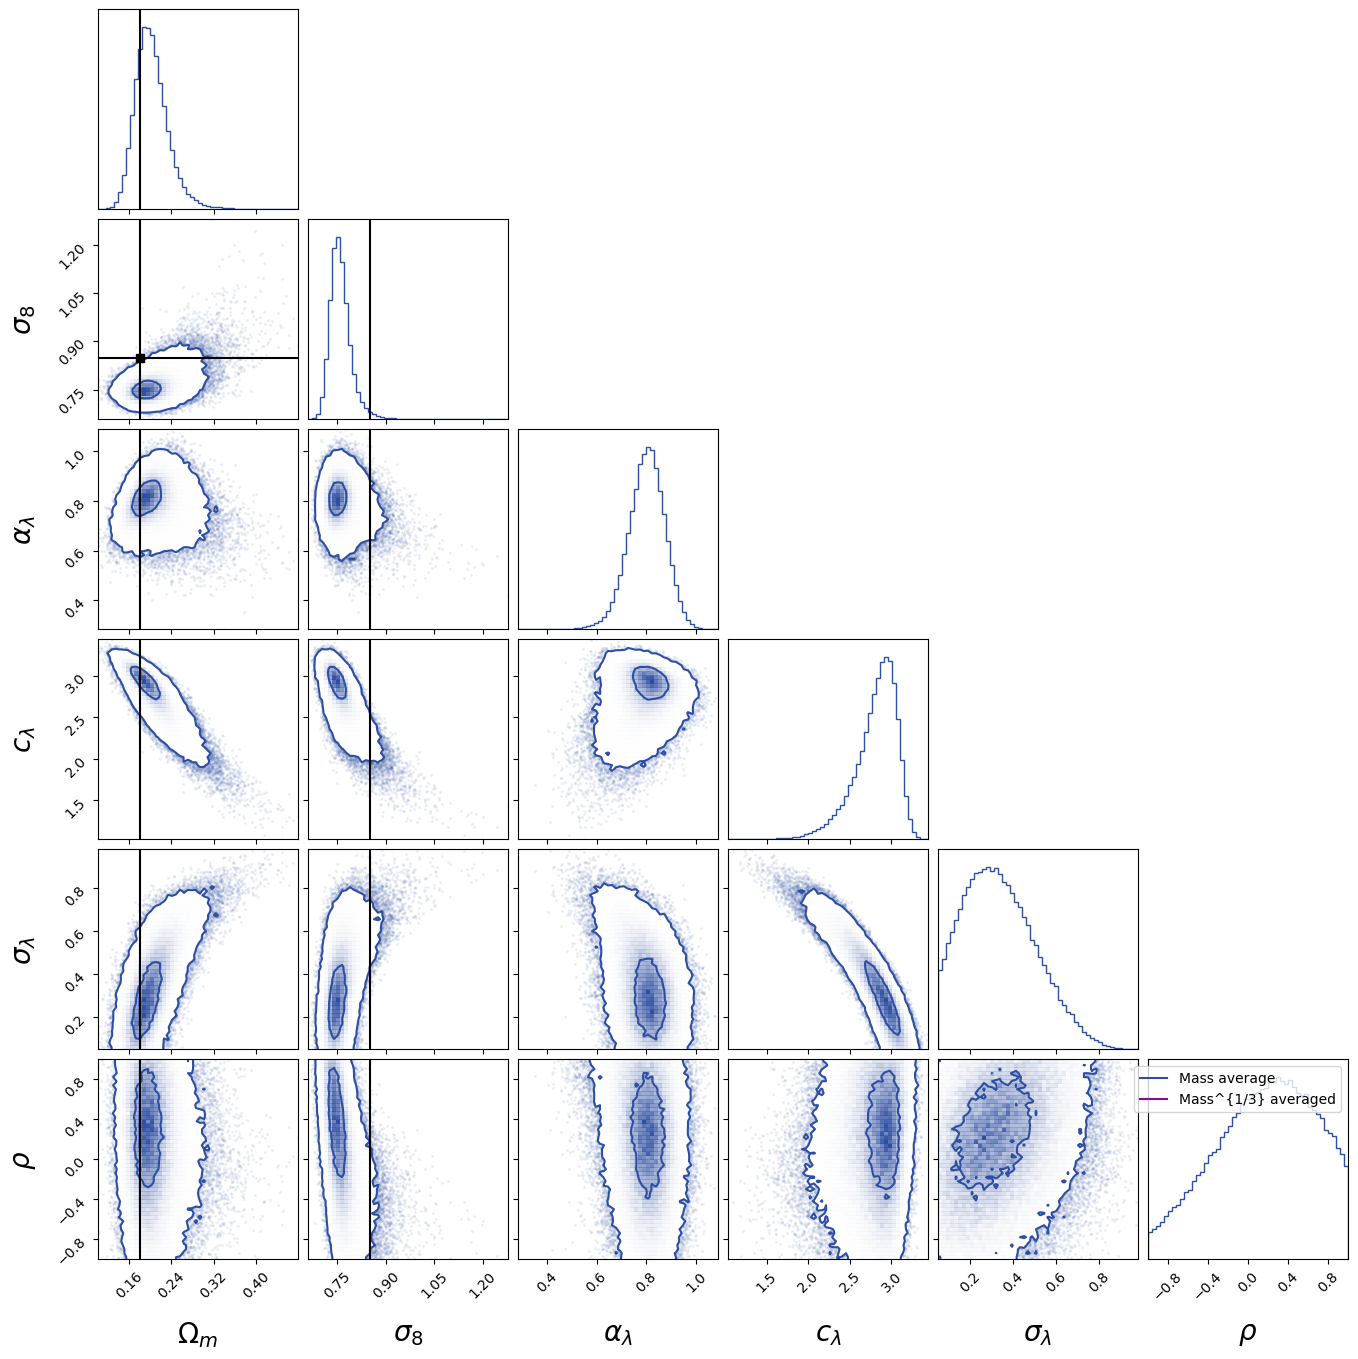

In [96]:
limits = [ ( 180 , 360 ), ( -20 , 60 ) , ( 0 , 200  ) ,( -0.01 , -0.002 )]
labels = ['$\Omega_m$' , '$\sigma_8$' , r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$']

labels = ['$\Omega_m$' , '$\sigma_8$' ,r'$\alpha_{\lambda}$' , r'$c_{\lambda}$' ,  r'$\sigma_{\lambda}$' , r'$\rho$',]
truths = [ 0.18 , 0.85 , None , None , None , None  ]

# labels = ['$\Omega_m$' , '$\sigma_8$', r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$']
# truths = [ 0.3 , 0.8 , 0.8 , 0.3 , 3  ]


figure = corner.corner( samples_des_y1.numpy(), 
                       levels = [ 0.393 , 0.98 ] ,  
                       bins = 50 , 
                       hist_kwargs={'density': True},
                       #range = limits,
                       labels = labels,
                       color ='#2d4ea1',
                       truths = truths,
                       truth_color = 'k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25} )

corner.corner( alt_samples_des_y1.numpy() , fig = figure , 
                       levels = [ 0.393 , 0.98 ] ,  
                       bins = 50 , 
                       hist_kwargs={'density': True},
                       #range = limits,
                       labels = labels,
                       color ='#880a94',
                       truths = truths,
                       truth_color = 'k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25}  )

plt.plot( [  0 ] , [ 0 ] , color = '#2d4ea1' , label = 'With richness-lensing correlation')
plt.plot( [  0 ] , [ 0 ] , color = '#880a94' , label = 'Without richness-lensing correlation')
plt.legend( loc="upper right" )
plt.savefig('both_bins.pdf')


print()

IndexError: list index out of range

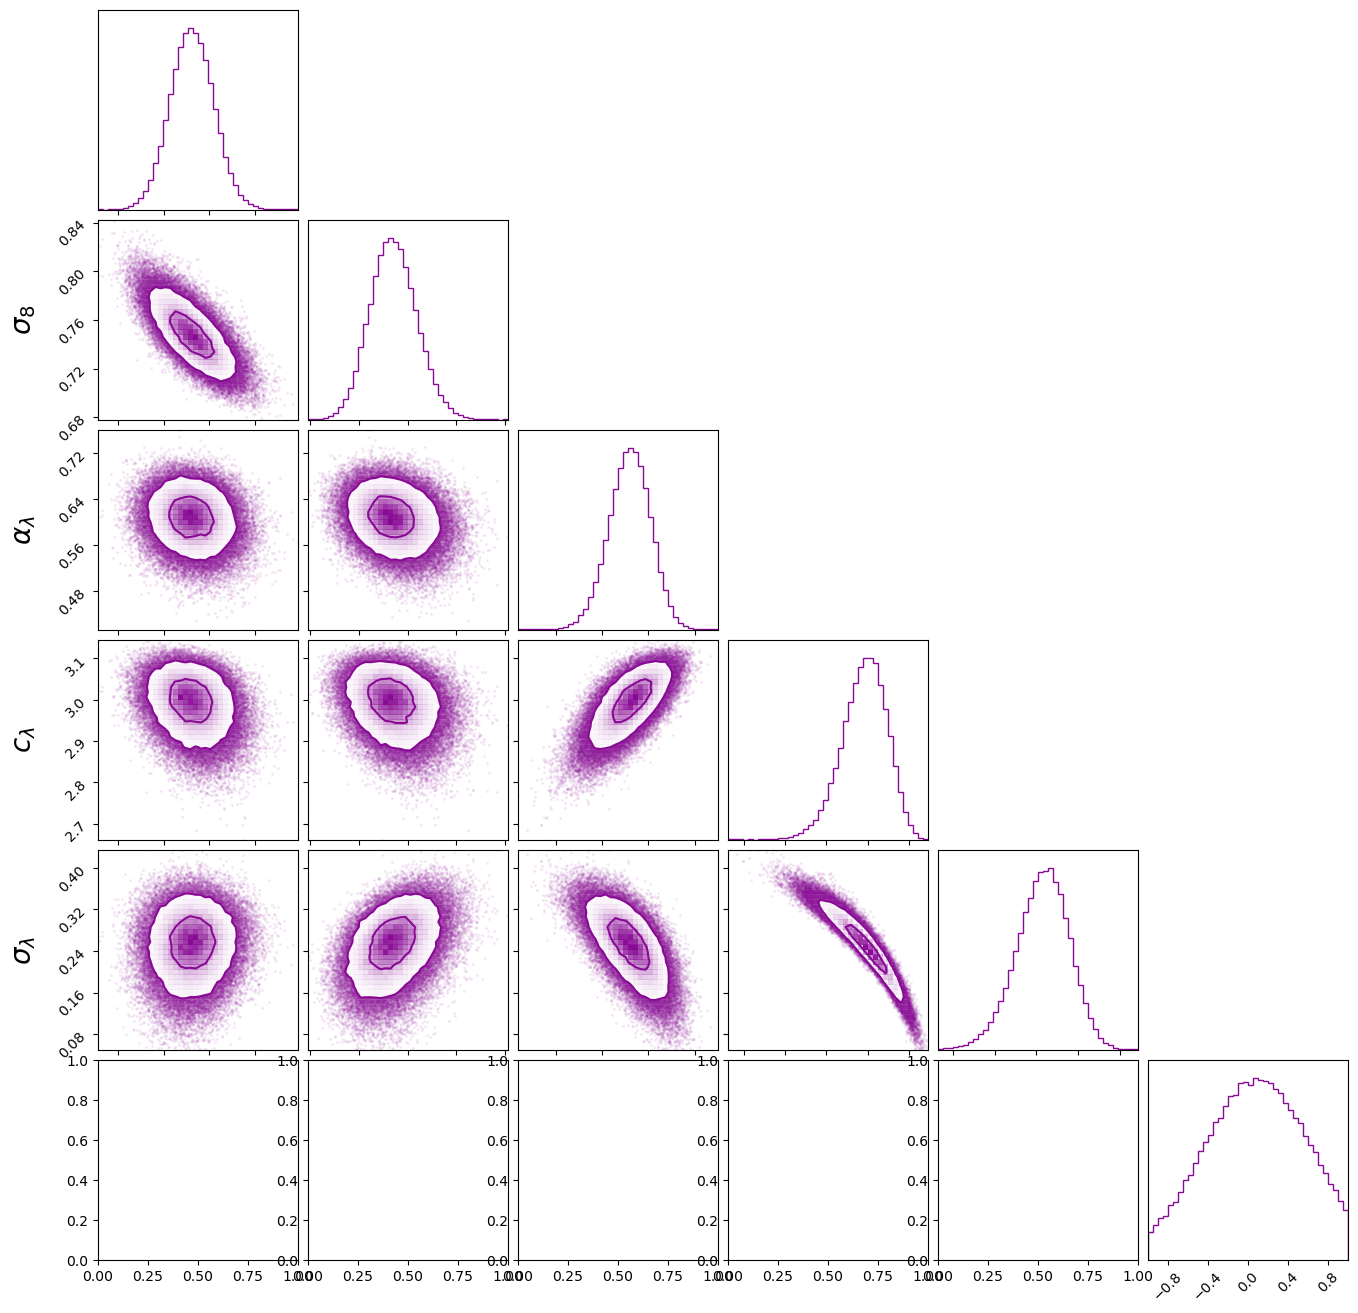

In [109]:
# labels = ['$\Omega_m$' , '$\sigma_8$' , '$w_0$', '$w_a$', r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$']
# truths = [ 0.3 , 0.8 , -1 , 0 , 0.8 , 0.3 , 3  ]

labels = ['$\Omega_m$' , '$\sigma_8$' , r'$w_0$' , r'$w_a$', r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$']
truths = [ 0.3 , 0.8 , -1 , 0 , 0.8 , 0.3 , 3  ]

labels = ['$\Omega_m$' , '$\sigma_8$' ,r'$\alpha_{\lambda}$' , r'$c_{\lambda}$' ,  r'$\sigma_{\lambda}$' ]
truths = [ 0.18 , 0.85 , None , None , None , None  ]

#truths = [ 264 , 48 , 369 , np.nan]
figure = corner.corner( alt_samples_des_y1.numpy() , 
                       levels = [ 0.393, 0.865 ] ,  
                       bins = 40 , 
                       hist_kwargs={'density': True},
                       #range = limits,
                       labels = labels,
                       color ='#880a94',
                       truths = truths,
                       truth_color = 'k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25})
plt.savefig('desy1.pdf')
print()

In [150]:
a

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [151]:
from IPython.display import display, Math

#labels_math = ['\Omega_m' , '\sigma_8' , 'w_0' , 'w_a' , r'\alpha_{\lambda}' , '\sigma_{\lambda}' , 'c_{\lambda}']
labels_math = ['\Omega_m' , '\sigma_8'  , r'\alpha_{\lambda}' , 'c_{\lambda}' , '\sigma_{\lambda}' , r'\rho']

mean_params = []
median_params = []
for i in range( len( labels_math )):
    mcmc = np.percentile( samples_des_y1.numpy() [:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_math[i])
    display(Math(txt))
    
    mean_params.append( mcmc[1] )
    median_params.append( np.median( mcmc[1]) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [152]:
1/0.8

1.25

In [ ]:
median_params

In [ ]:
mean_params

In [50]:
stacked_simulator_w0wa = simulation.Universe_simulation( 'stacked_counts' ,
                                                    variable_params=['omega_m', 'sigma_8' ,'w_0' , 'w_a', 'alpha' , 'c' , 'sigma' , 'r' ] )

stacked_simulator_w0wa.dOmega = 1500/41253 * 4*np.pi
stacked_simulator_w0wa.richness_bins = des_lambda_bins
stacked_simulator_w0wa.redshift_bins = des_z_bins
stacked_simulator_w0wa.z_bins = np.arange( 0.15 , 0.7 , 0.05 )
stacked_simulator_w0wa.sigma_mwl = 0.3
stacked_simulator_w0wa.log10ms = np.arange(13.1, 15.5, stacked_simulator_w0wa.dlog10m)

In [ ]:
# infer posteriors
des_posterior_w0wa = infer( stacked_simulator_w0wa.run_simulation , 
                           w0_plus_wa_positive_prior, 
                           method = "SNPE", 
                           num_simulations = 20000 , 
                           num_workers = 40 )

/pbs/home/c/cmurray/.conda/envs/sbi/lib/python3.9/site-packages/sbi/utils/user_input_checks_utils.py:392: UserWarning: No prior bounds were passed, consider passing lower_bound
            and / or upper_bound if your prior has bounded support.
  warnings.warn(
Running 20000 simulations in 20000 batches.:  63%|██████▎   | 12609/20000 [1:13:26<56:41,  2.17it/s]  

In [78]:
nsamples = 100000
samples_des_y1_w0wa = des_posterior_w0wa.sample( (nsamples,), x = des_stacked_results )

Drawing 100000 posterior samples: 100%|██████████| 100000/100000 [00:01<00:00, 85941.74it/s]


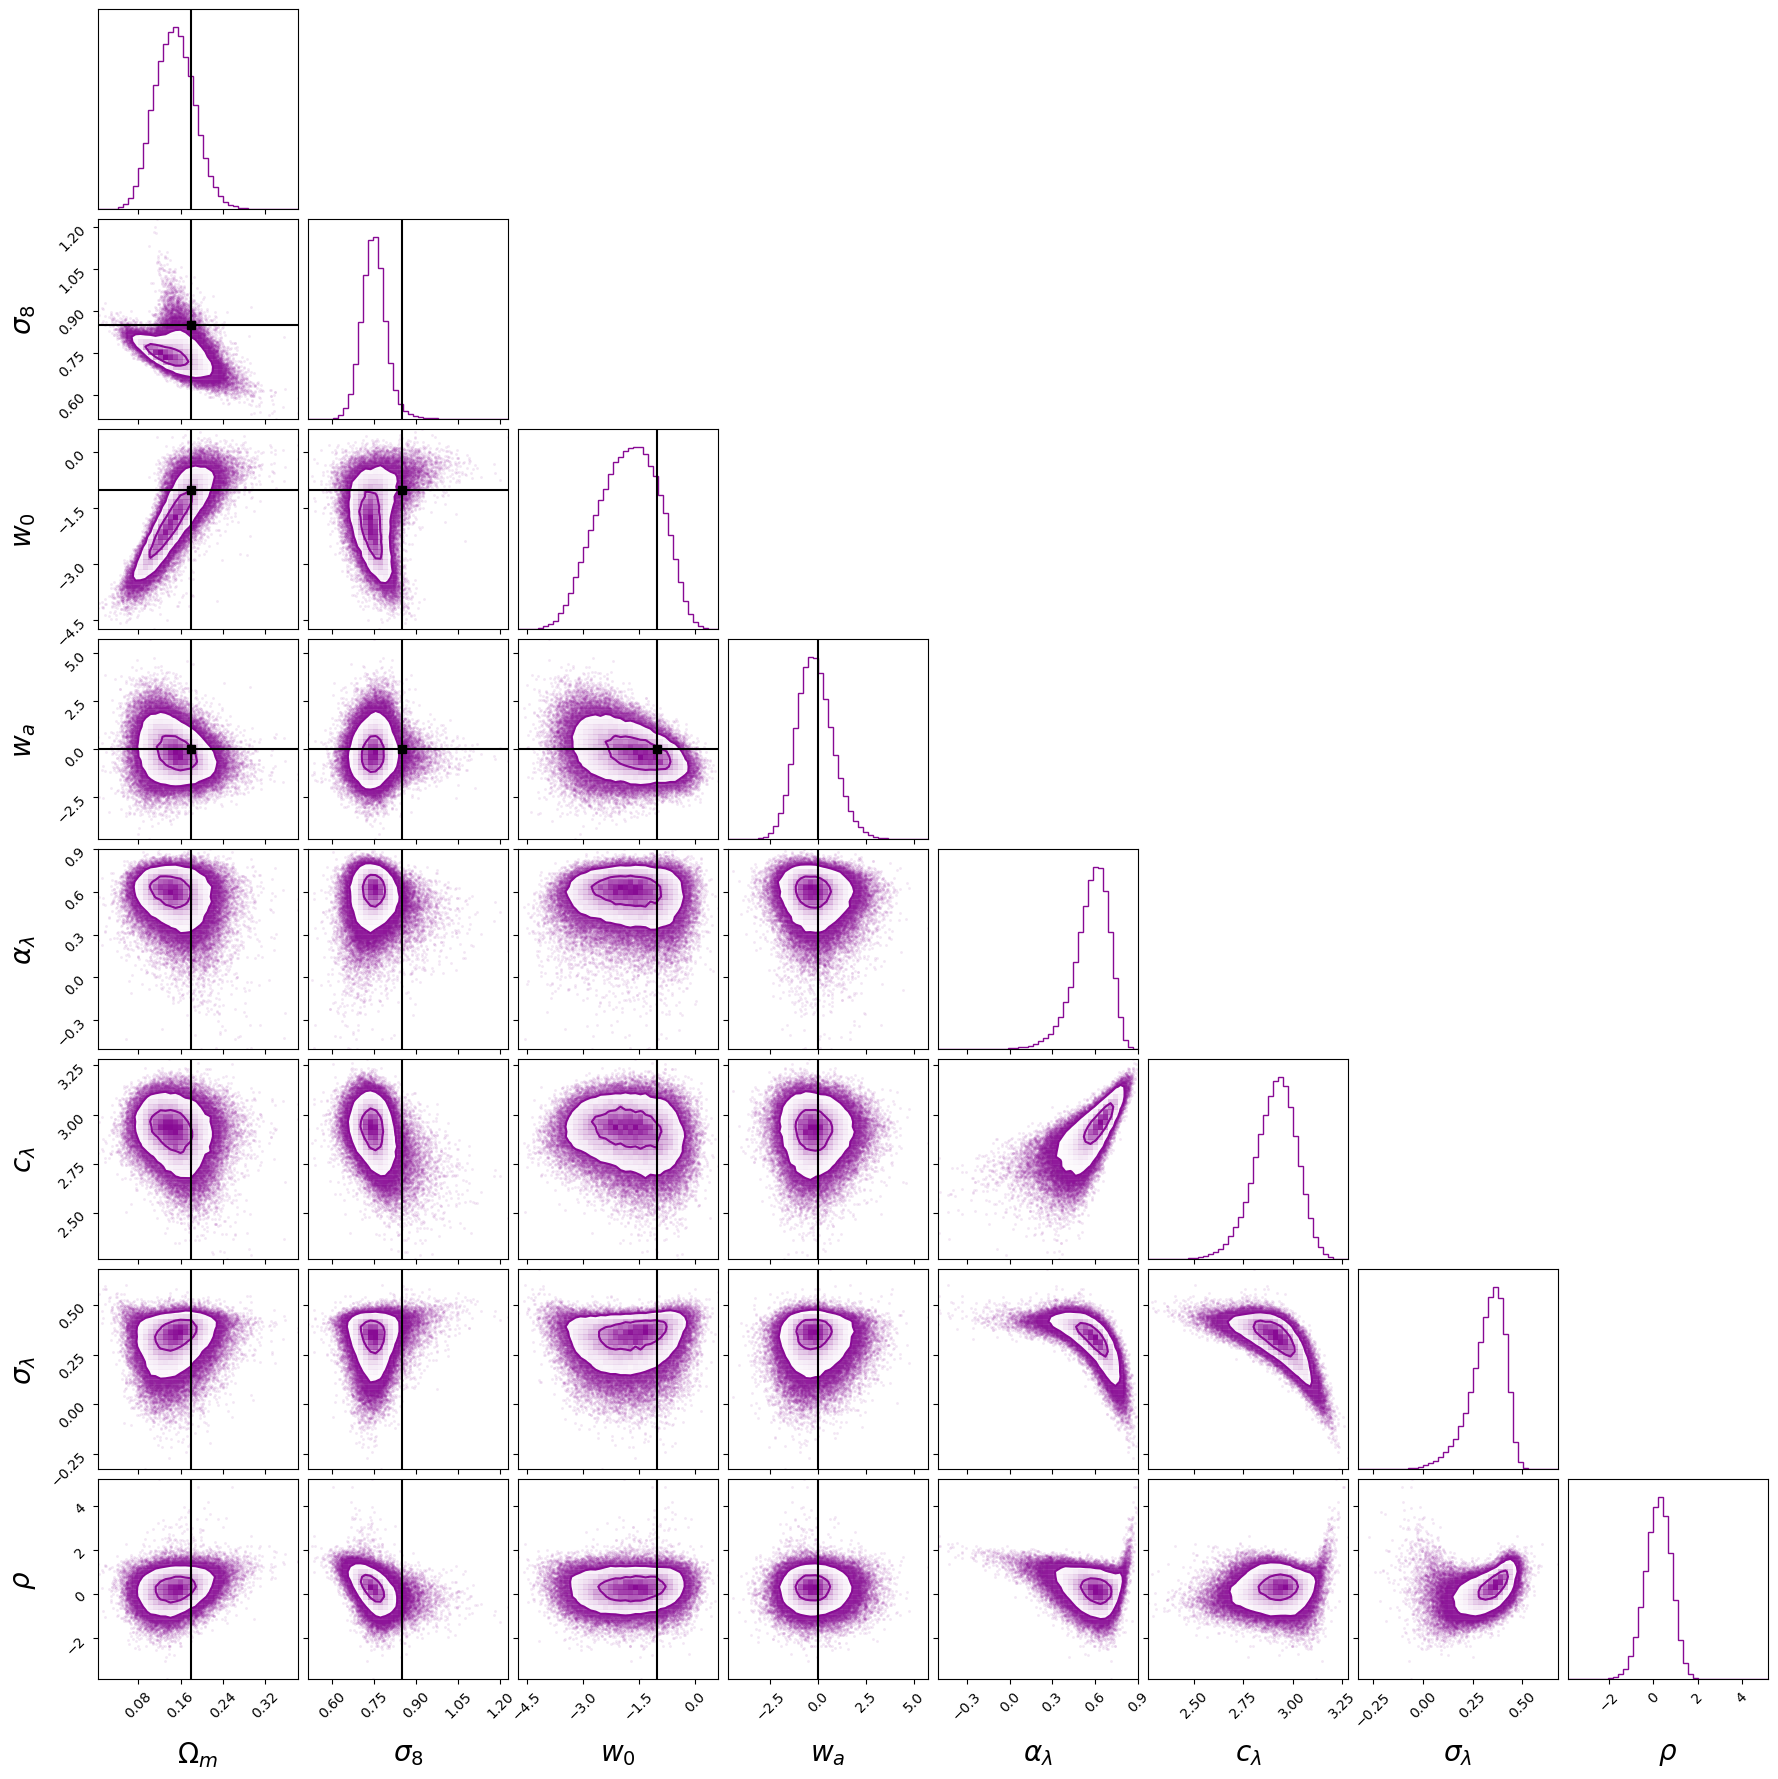

In [79]:
# labels = ['$\Omega_m$' , '$\sigma_8$' , '$w_0$', '$w_a$', r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$']
# truths = [ 0.3 , 0.8 , -1 , 0 , 0.8 , 0.3 , 3  ]

labels = ['$\Omega_m$' , '$\sigma_8$' , r'$w_0$' , r'$w_a$', r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$']
truths = [ 0.3 , 0.8 , -1 , 0 , 0.8 , 0.3 , 3  ]

labels = ['$\Omega_m$' , '$\sigma_8$' , r'$w_0$' , r'$w_a$',r'$\alpha_{\lambda}$' , r'$c_{\lambda}$' ,  r'$\sigma_{\lambda}$' , r'$\rho$',]
truths = [ 0.18 , 0.85 , -1 , 0 , None , None , None , None  ]

#truths = [ 264 , 48 , 369 , np.nan]
figure = corner.corner( samples_des_y1_w0wa.numpy() , 
                       levels = [ 0.393, 0.865 ] ,  
                       bins = 40 , 
                       hist_kwargs={'density': True},
                       #range = limits,
                       labels = labels,
                       color ='#880a94',
                       truths = truths,
                       truth_color = 'k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25})
plt.savefig('desy1.pdf')
print()

In [81]:
from IPython.display import display, Math

#labels_math = ['\Omega_m' , '\sigma_8' , 'w_0' , 'w_a' , r'\alpha_{\lambda}' , '\sigma_{\lambda}' , 'c_{\lambda}']
labels_math = ['\Omega_m' , '\sigma_8' , 'w_0' , 'w_a' , r'\alpha_{\lambda}' , 'c_{\lambda}' , '\sigma_{\lambda}' , r'\rho']

mean_params = []
median_params = []
for i in range( len( labels_math )):
    mcmc = np.percentile( samples_des_y1_w0wa.numpy() [:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_math[i])
    display(Math(txt))
    
    mean_params.append( mcmc[1] )
    median_params.append( np.median( mcmc[1]) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [83]:
1/0.7

1.4285714285714286

In [ ]:
# same S8 as the fiducial DES analysis
S8 = 1 * ( 0.449 / 0.3 )**0.5
S8

In [54]:
# same S8 as the fiducial DES analysis
S8 = 0.6 * ( 0.359 / 0.3 )**0.5
S8

0.6563535632568775

In [55]:
sim_obs = stacked_simulator.run_simulation( torch.Tensor( [ 0.2 , 0.75 , -1 , 0 , 0.8 , 0.1 , 3 ] )  )

In [ ]:
sim_n_clusters = sim_obs[:12].reshape( 4 , 3 )
sim_mwl_mean = sim_obs[12:].reshape( 4 , 3 )

sim_n_clusters_0 = sim_n_clusters.T[0]
sim_n_clusters_1 = sim_n_clusters.T[1]
sim_n_clusters_2 = sim_n_clusters.T[2]

sim_mwl_mean_0 = sim_mwl_mean.T[0]
sim_mwl_mean_1 = sim_mwl_mean.T[1]
sim_mwl_mean_2 = sim_mwl_mean.T[2]

In [ ]:
plt.figure( figsize = ( 12, 4 ))
plt.subplot(121)
plt.plot( des_lambda_cent , n_clusters_0 , 'b-' )
plt.plot( des_lambda_cent , n_clusters_1 , 'c-' )
plt.plot( des_lambda_cent , n_clusters_2 , 'g-' )

plt.plot( des_lambda_cent , sim_n_clusters_0 , 'b--' )
plt.plot( des_lambda_cent , sim_n_clusters_1 , 'c--' )
plt.plot( des_lambda_cent , sim_n_clusters_2 , 'g--' )
plt.xscale('log')
plt.yscale('log')
plt.yticks( [ 100 , 200 , 500 , 1000 , 2000 ], labels = [ 100 , 200 , 500 , 1000 , 2000 ])
plt.xlim( 20 , 200 )
plt.ylim( 50 , 6000 )

plt.subplot(122)
plt.plot( des_lambda_cent , mwl_mean_0 , 'b-' )
plt.plot( des_lambda_cent , mwl_mean_1 , 'c-' )
plt.plot( des_lambda_cent , mwl_mean_2 , 'g-' )

plt.plot( des_lambda_cent , sim_mwl_mean_0 , 'b--' )
plt.plot( des_lambda_cent , sim_mwl_mean_1 , 'c--' )
plt.plot( des_lambda_cent , sim_mwl_mean_2 , 'g--' )
plt.xscale('log')
plt.xlim( 20 , 200 )
plt.ylim( 13.7 , 15 )